In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urielplus.urielplus import URIELPlus           # URIELPlus
from sklearn.preprocessing import StandardScaler    # Standardization
from sklearn.decomposition import PCA               # Dimensionality reduction
from sklearn.ensemble import RandomForestClassifier # Feature Importance

# __URIEL++ Challenge Problem Attempted Solution__
Name: Jun Bin Cheng 

School: Ontario Tech University

Program: Software Engineering

Year: 3

In [21]:
uriel = URIELPlus()
uriel.set_aggregation('U')
uriel.aggregate()

# Get typological data
features = uriel.get_typological_features_array()
data = uriel.get_typological_data_array()
data = np.squeeze(data)   # Remove singleton dimension resulting from aggregation

2024-12-27 13:23:28,597 - root - INFO - Creating union of data across sources....
2024-12-27 13:23:28,974 - root - INFO - Union across sources creation complete.


### __Dimensionality Reduction__
To reduce the dimensions of the typological dataset, I used PCA.  First, I created a scree plot that shows how much variation is explained by the first 41 Principal Components, corresponding to 95% of data.  Based on the graph, the 9th PC appears to be an elbow point, as adding more PCs beyond it had heavy diminishing returns.  So, I decided to use the first 9 PCs, corresponding to 85% of variation explained by the PCs.

In [15]:
# Scale data before applying PCA
scaler = StandardScaler()
scaled_data=scaler.fit_transform(data)
scaled_data.shape

(7970, 289)

In [16]:
# Compute how many principal components by calculating how many PCs are needed to explain at least 95% of the variance
VARIANCE_THRESHOLD = 0.95

# Fit PCA to the scaled data
pca = PCA()
pca.fit(scaled_data)

# The cumulative sum of eigenvalues descending is the amount of explained variance by the first n PCs
eigenvalues_descending = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(eigenvalues_descending)
number_of_pcs = np.argmax(cumulative_variance >= VARIANCE_THRESHOLD) + 1
print(f"{VARIANCE_THRESHOLD * 100}% of variance is explained by {number_of_pcs} principal components.")

95.0% of variance is explained by 41 principal components.


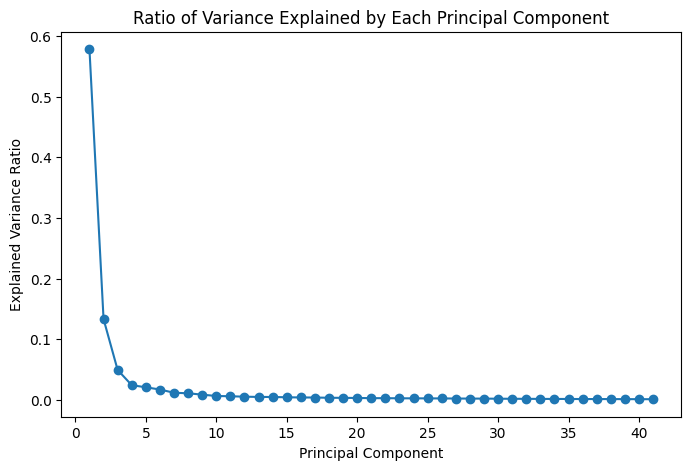

The 9th PC appears to be an elbow point in the scree plot. Therefore, I will use the first 9 PCs for PCA.


In [17]:
# Scree Plot to visualize the explained variance by each PC
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues_descending[:number_of_pcs]) + 1), eigenvalues_descending[:number_of_pcs], 'o-')
plt.title('Ratio of Variance Explained by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()
print("The 9th PC appears to be an elbow point in the scree plot. Therefore, I will use the first 9 PCs for PCA.")

In [18]:
# Choose 9 PCs to keep, corresponding to 85% of the variance
NUM_PCS_KEPT = 9

# Reduce the dimensionality of the features to `number_of_pcs` using PCA
pca = PCA(n_components=NUM_PCS_KEPT)
reduced_data = pca.fit_transform(scaled_data)
reduced_data.shape

(7970, 9)

### __Feature Importance__
To conduct feature importance on the new dataset created by PCA, I first attempted to plot bar charts showing the loadings of each feature for the first 3 principal components.  I noticed that in each chart, 1 of the 3 groups of data (Syntactic, Phonological, and Inventory) had a tendency skew the data (i.e., had higher contributions to the PC than the other 2 groups).  Based on this observation, I plotted new bar charts that showed the proportion of contributions each of the 3 groups had on the PC.

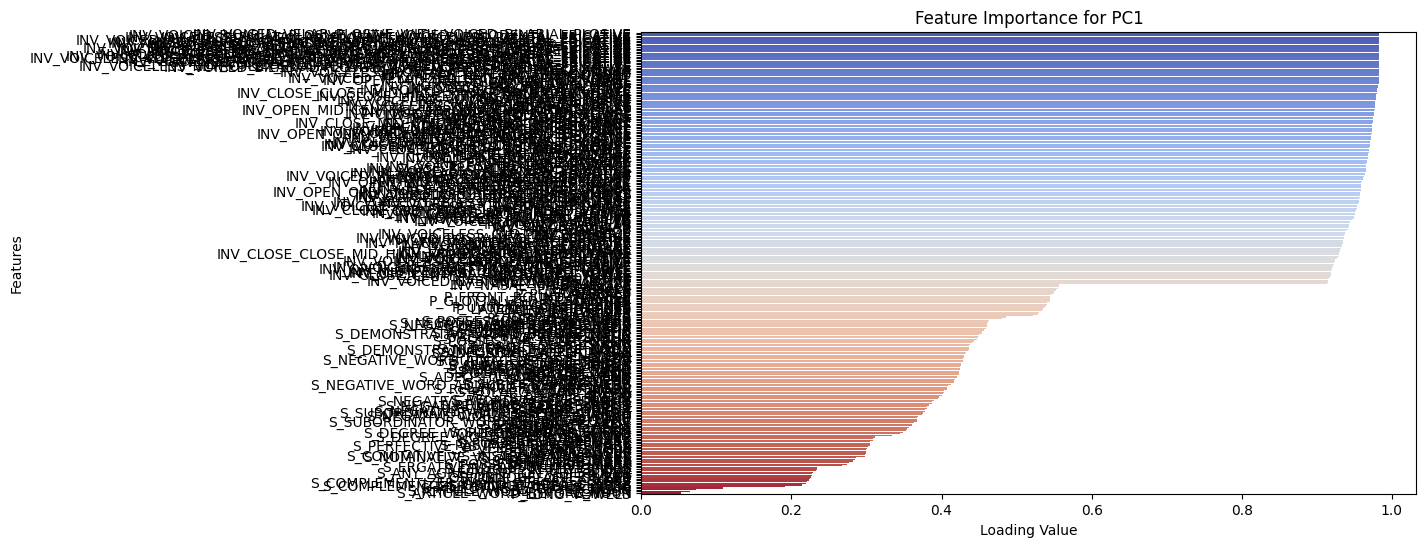

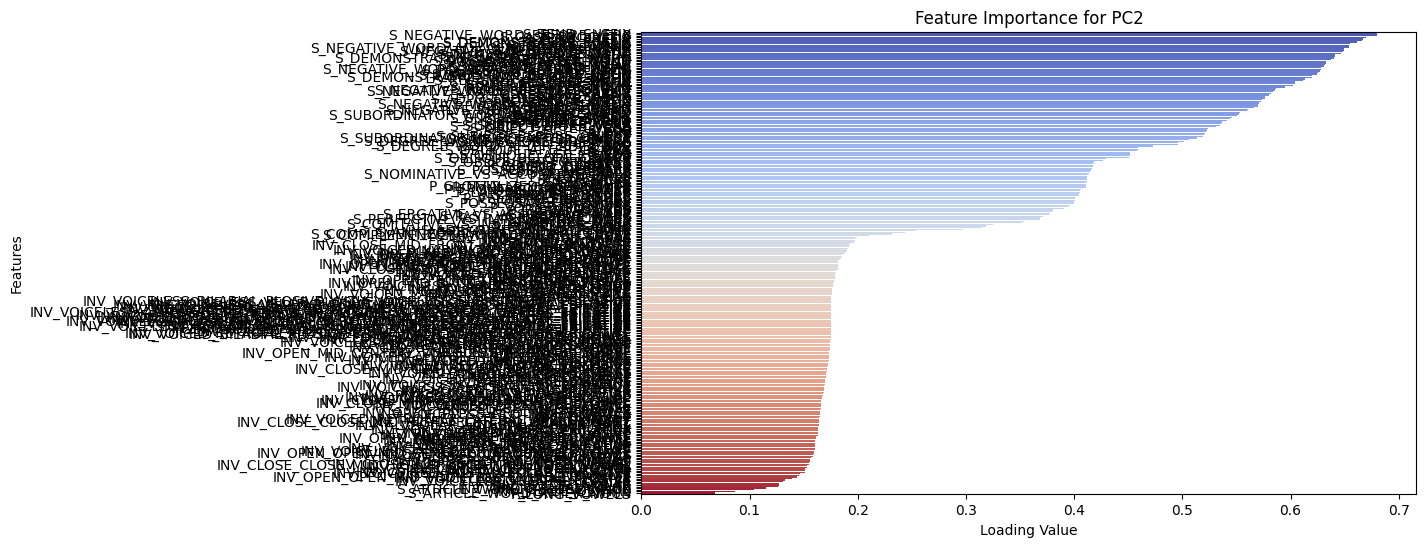

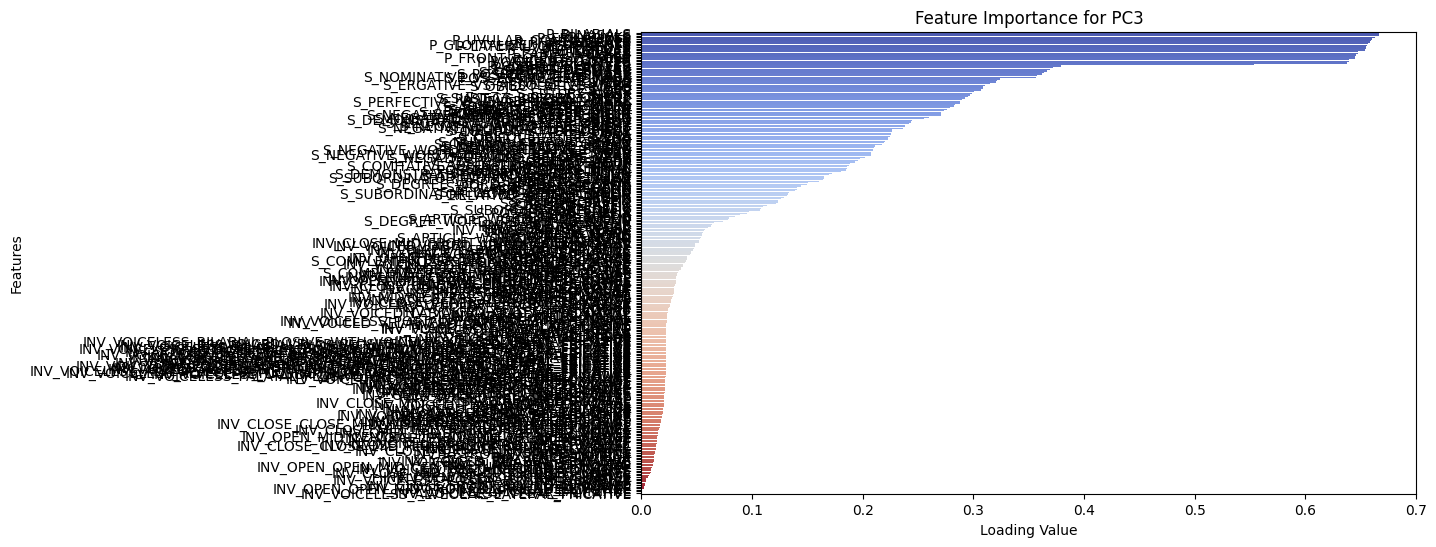

In [19]:
# Find loadings of the PCs (i.e., determine which features are most important for each PC)
loadings = pd.DataFrame(
    pca.components_.T * np.sqrt(pca.explained_variance_),                       # Loadings
    index=[f"{feature}" for feature in features],                               # Features
    columns=[f"PC{eigenvector + 1}" for eigenvector in range(NUM_PCS_KEPT)]    # Principal components    
)

# Only show the first 3 PCs as they account for nearly 80% of the variance alone
for pc in ["PC1", "PC2", "PC3"]:
    n_largest_loadings = loadings[pc].abs().sort_values(ascending=False)

    # Plot horizontal bar plot for the largest loadings for each PC
    plt.figure(figsize=(10, 6))  # Adjust size as needed
    sns.barplot(x=n_largest_loadings.values, y=n_largest_loadings.index, palette='coolwarm', hue=n_largest_loadings.index)
    plt.title(f'Feature Importance for {pc}')
    plt.xlabel('Loading Value')
    plt.ylabel('Features')
    plt.show()

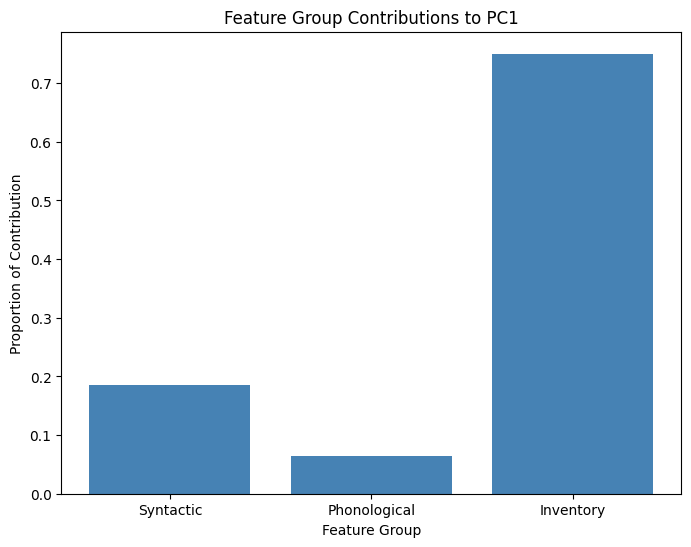

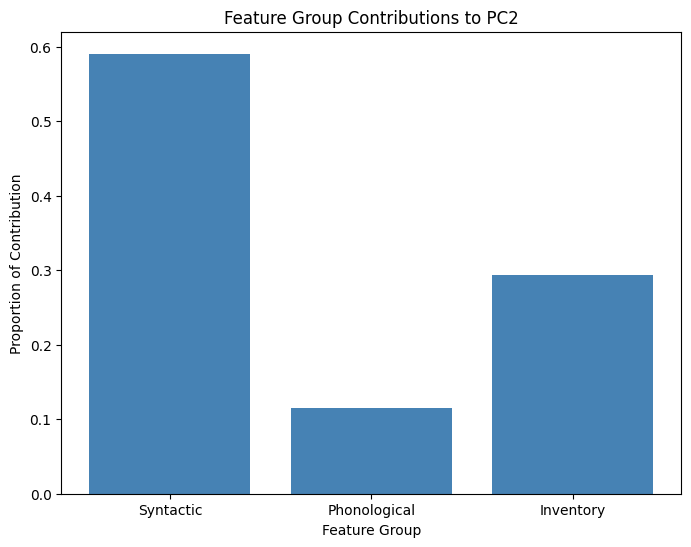

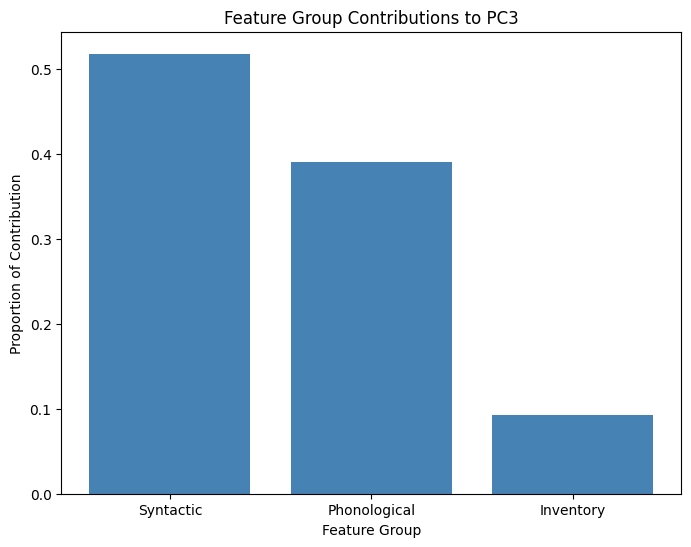

In [20]:
"""
    From the above graphs, despite the overlapping text, there seems to be a trend where 
    the "most important" features in each PC being of a certain group (Syntactic, Phonological, Inventory).
    To confirm this, aggregate the importance of features by group and plot the percentage importance for each group in each PC.
"""
# Group features by Syntactic, Phonological, and Inventory according to their prefixes in the dataset
groups = {"Syntactic": [], "Phonological": [], "Inventory": []}
for feature in loadings.index:
    if feature.startswith("S_"):
        groups["Syntactic"].append(feature)
    elif feature.startswith("P_"):
        groups["Phonological"].append(feature)
    elif feature.startswith("INV_"):
        groups["Inventory"].append(feature)

# Compute aggregated importance by group for each PC
for pc in ["PC1", "PC2", "PC3"]:
    total_importance = loadings.loc[:, pc].abs().sum()
    group_importance = {group: loadings.loc[features, pc].abs()[features].sum() / total_importance for group, features in groups.items()}
    
    # Plot group importance
    plt.figure(figsize=(8, 6))
    plt.bar(group_importance.keys(), group_importance.values(), color="steelblue")
    plt.title(f"Feature Group Contributions to {pc}")
    plt.xlabel("Feature Group")
    plt.ylabel("Proportion of Contribution")
    plt.show()